# Image classification from MNIST dataset using CNN

In [10]:
import torch
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(777)  # reproducibility

In [2]:
# hyper-parameters
batch_size = 32
keep_prob = 1 # 0.7

In [3]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True)

In [4]:
# Display informations about the dataset
print('The training dataset:\t',mnist_train)
print('\nThe testing dataset:\t',mnist_test)

The training dataset:	 Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: MNIST_data/
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

The testing dataset:	 Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: MNIST_data/
    Transforms (if any): ToTensor()
    Target Transforms (if any): None


In [5]:
# Implementation of CNN/ConvNet Model using PyTorch (depicted in the picture above)

class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=1 - keep_prob))
        # L3 ImgIn shape=(?, 7, 7, 64)
        #    Conv      ->(?, 7, 7, 128)
        #    Pool      ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            torch.nn.Dropout(p=1 - keep_prob))

        # L4 FC 4x4x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - keep_prob))
        # L5 Final FC 625 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.fc2(out)
        return out


# instantiate CNN model
model = CNN()
model

C:\Users\B\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Dropout(p=0)
  )
  (fc1): Linear(in_features=2048, out_features=625, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=2048, out_features=625, bias=True)
    (1): ReLU()
    (2): Dropout(p=0)
  )
  (fc2): Linear(in_features=625, out_features=10, bias=True)
)

In [6]:
for param in model.parameters():
    print(param.size())

torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([625, 2048])
torch.Size([625])
torch.Size([10, 625])
torch.Size([10])


In [7]:
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()    # Softmax is internally computed.
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [8]:

print('Training the Deep Learning network ...')
train_cost = []
train_accu = []

training_epochs = 15
total_batch = len(mnist_train) // batch_size

print('Size of the training dataset is {}'.format(mnist_train.data.size()))
print('Size of the testing dataset is {}'.format(mnist_test.data.size()))
print('Batch size is : {}'.format(batch_size))
print('Total number of batches is : {0:2.0f}'.format(total_batch))
print('\nTotal number of epochs is : {0:2.0f}'.format(training_epochs))

for epoch in range(training_epochs):
    avg_cost = 0
    for i, (batch_X, batch_Y) in enumerate(data_loader):
        X = Variable(batch_X)    # image is already size of (28x28), no reshape
        Y = Variable(batch_Y)    # label is not one-hot encoded

        optimizer.zero_grad() # <= initialization of the gradients
        
        # forward propagation
        hypothesis = model(X)
        cost = criterion(hypothesis, Y) # <= compute the loss function
        
        # Backward propagation
        cost.backward() # <= compute the gradient of the loss/cost function     
        optimizer.step() # <= Update the gradients
             
        # Print some performance to monitor the training
        prediction = hypothesis.data.max(dim=1)[1]
        train_accu.append(((prediction.data == Y.data).float().mean()).item())
        train_cost.append(cost.item())   
        if i % 200 == 0:
            print("Epoch= {},\t batch = {},\t cost = {:2.4f},\t accuracy = {}".format(epoch+1, i, train_cost[-1], train_accu[-1]))
       
        avg_cost += cost.data / total_batch

    print("[Epoch: {:>4}], averaged cost = {:>.9}".format(epoch + 1, avg_cost.item()))


print('Learning Finished!')
#  _, argmax = torch.max(outputs, 1)
accuracy = (labels == argmax.squeeze()).float().mean()

Training the Deep Learning network ...
Size of the training dataset is torch.Size([60000, 28, 28])
Size of the testing dataset is torch.Size([10000, 28, 28])
Batch size is : 32
Total number of batches is : 1875

Total number of epochs is : 15
Epoch= 1,	 batch = 0,	 cost = 2.3377,	 accuracy = 0.0625
Epoch= 1,	 batch = 200,	 cost = 0.3542,	 accuracy = 0.875
Epoch= 1,	 batch = 400,	 cost = 0.0229,	 accuracy = 1.0
Epoch= 1,	 batch = 600,	 cost = 0.1765,	 accuracy = 0.9375
Epoch= 1,	 batch = 800,	 cost = 0.1133,	 accuracy = 0.96875
Epoch= 1,	 batch = 1000,	 cost = 0.0891,	 accuracy = 0.96875
Epoch= 1,	 batch = 1200,	 cost = 0.0815,	 accuracy = 0.96875
Epoch= 1,	 batch = 1400,	 cost = 0.0166,	 accuracy = 1.0
Epoch= 1,	 batch = 1600,	 cost = 0.0871,	 accuracy = 0.96875
Epoch= 1,	 batch = 1800,	 cost = 0.0206,	 accuracy = 1.0
[Epoch:    1], averaged cost = 0.125057846
Epoch= 2,	 batch = 0,	 cost = 0.1577,	 accuracy = 0.875
Epoch= 2,	 batch = 200,	 cost = 0.0552,	 accuracy = 0.96875
Epoch= 2,	 

NameError: name 'labels' is not defined

(<matplotlib.axes._subplots.AxesSubplot at 0x29f57a1ab00>,
 (0, 100))

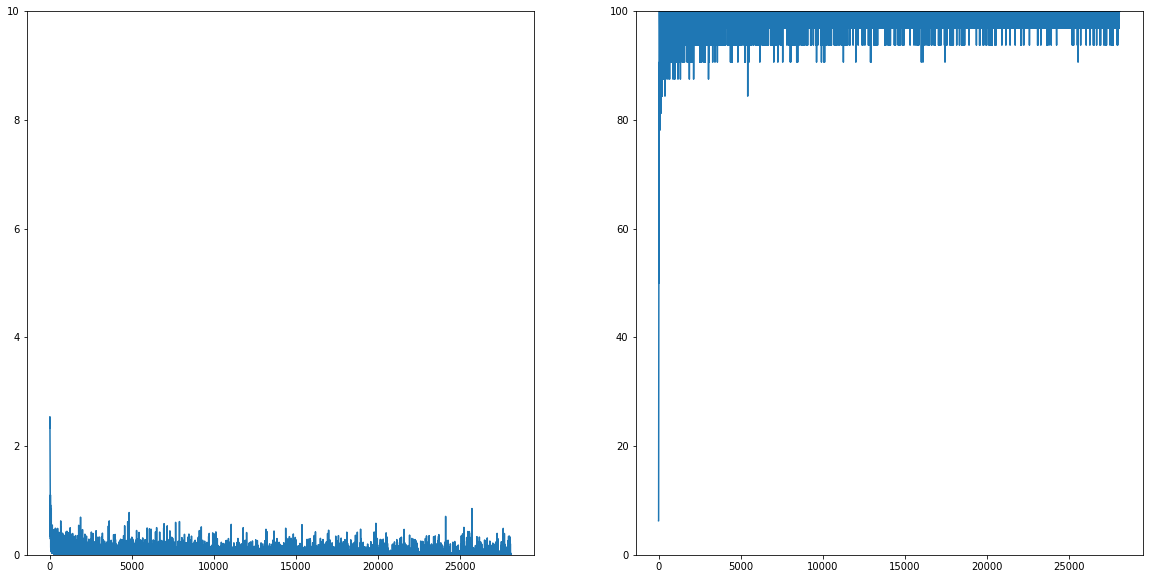

In [11]:
from matplotlib import pylab as plt
plt.figure(figsize=(20,10))
plt.subplot(121), plt.plot(np.arange(len(train_cost)), train_cost), plt.ylim([0,10])
plt.subplot(122), plt.plot(np.arange(len(train_accu)), 100 * torch.as_tensor(train_accu).numpy()), plt.ylim([0,100])

In [12]:
cost.item?

In [13]:
# Test model and check accuracy
model.eval()    # set the model to evaluation mode (dropout=False)

X_test = Variable(mnist_test.data.view(len(mnist_test), 1, 28, 28).float())
Y_test = Variable(mnist_test.targets)

prediction = model(X_test)

# Compute accuracy
correct_prediction = (torch.max(prediction.data, dim=1)[1] == Y_test.data)
accuracy = correct_prediction.float().mean().item()
print('\nAccuracy: {:2.2f} %'.format(accuracy*100))


Accuracy: 79.81 %


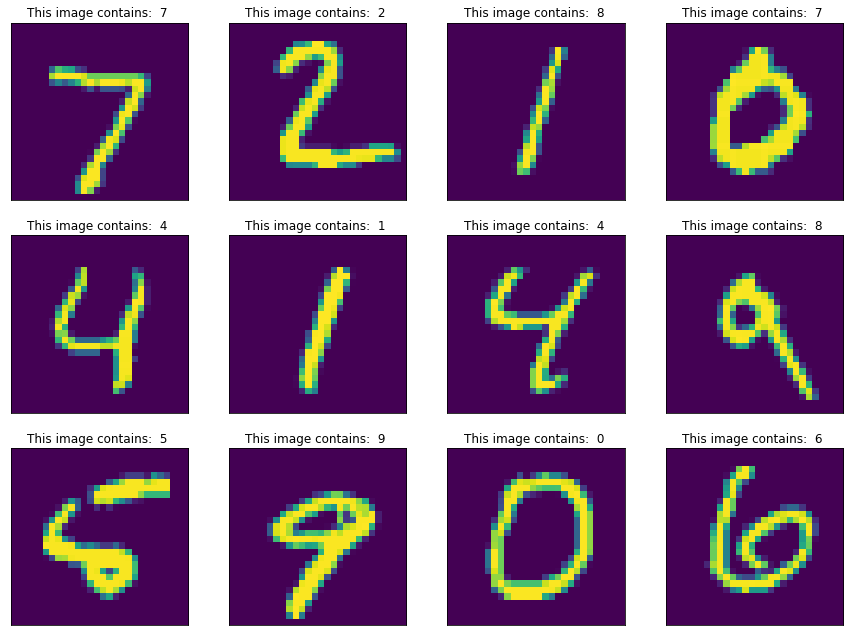

In [14]:
plt.figure(figsize=(15,15), facecolor='white')
for i in torch.arange(0,12):
  val, idx = torch.max(prediction, dim=1)
  plt.subplot(4,4,i+1)  
  plt.imshow(X_test[i][0])
  plt.title('This image contains: {0:>2} '.format(idx[i].item()))
  plt.xticks([]), plt.yticks([])
  plt.plt.subplots_adjust()